# No splitting included

## Performance:
- Ran for 1 year of data and a total of 18 identified modes
- Convergence took 6642.93 seconds == 2.2 hours (!)
- The l=2 heights towards the high frequency end seem too large.
- The heights & widths are informed by data alone and not theory, so theres no constraint making them smaller than the l=1s

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import corner
import matplotlib
import pystan
import pickle
import os
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)
matplotlib.rcParams['text.usetex'] = False

#The stellar parameters are for 16 Cyg A
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')
sel = [(ff >= 1700) & (ff <= 2700)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

In [3]:
locs = np.genfromtxt('locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid-4:mid+5,0]
l2s = locs[mid-5:mid+4:,2]
modelocs = np.append(l0s, l2s)
modeids = [0]*len(l0s) + [2]*len(l2s)

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


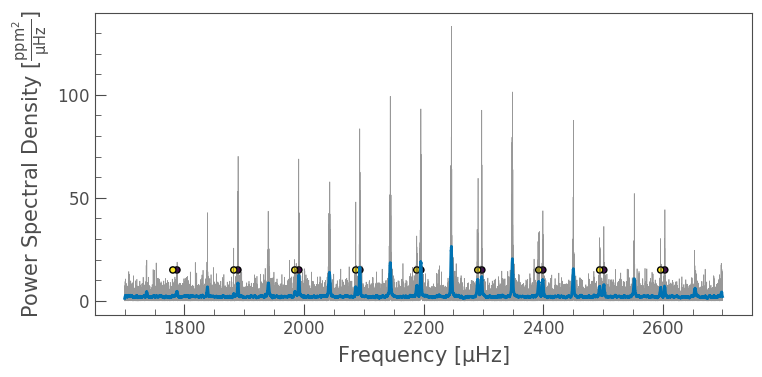

In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

Lets fit a group of lorentzians to these data!

In [6]:
overwrite = False
nosplit = '''
functions{      
    vector lorentzian(real loc, int l,vector f, real H, real w){
        return H ./ (1 + (4/w^2) * square(f - loc));
    }
}
data{
    int N;            // Number of data points
    int M;            // Number of modes
    vector[N] f;      // Frequency
    vector[N] p;      // Power
    real asy_locs[M]; // Mode locations (this will have to change for multiple n modes)
    int asy_ids[M];   // The ID's of the modes
}
parameters{
    real logAmp[M];         // Mode amplitude in log space
    real logGamma[M];       // Mode linewidth in log space
    real locs[M];           // True mode locations
    real<lower=0.1> b;      // Background
}
transformed parameters{
    real H[M];       // Mode height
    real w[M];       // Mode linewidth
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform mode linewidth from log space
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    vector[N] modes; // Our Model
    int l;           // The radial degree
    
    modes = rep_vector(b, N);
    for (mode in 1:M){        // Iterate over all modes passed in
        l = asy_ids[mode];    // Identify the Mode ID
        modes += lorentzian(locs[mode], l, f, H[mode], w[mode]);
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    logGamma ~ normal(0, .05);
    locs ~ normal(asy_locs, 1);
    
    b ~ normal(1.,.1);
}
'''
model_path = 'nosplit.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = nosplit, model_name='nosplit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = nosplit, model_name='nosplit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

Saving Stan Model


INFO:pystan:COMPILING THE C++ CODE FOR MODEL nosplit_02ebfa7cce12bde68280238f202fa2d1 NOW.


In [7]:
data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'asy_locs':modelocs,
        'asy_ids':modeids}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma' : np.zeros(len(modelocs)),
        'locs' : modelocs}

In [8]:
nchains = 4
fit = sm.sampling(data=data, iter=2000, chains=nchains,verbose=False, init = [init for n in range(nchains)])

In [9]:
print(fit)

Inference for Stan model: nosplit_02ebfa7cce12bde68280238f202fa2d1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]      1.04  1.7e-3   0.12   0.79   0.96   1.05   1.13   1.27   5136    1.0
logAmp[2]      1.46  9.4e-4   0.07   1.32   1.41   1.46    1.5   1.59   5605    1.0
logAmp[3]       1.7  8.1e-4   0.06   1.58   1.66    1.7   1.74   1.81   5308    1.0
logAmp[4]      1.84  7.0e-4   0.05   1.73   1.81   1.84   1.88   1.94   5668    1.0
logAmp[5]      1.95  6.6e-4   0.05   1.85   1.92   1.95   1.99   2.05   5698    1.0
logAmp[6]      1.66  8.7e-4   0.06   1.54   1.62   1.67   1.71   1.79   5290    1.0
logAmp[7]      1.58  8.6e-4   0.06   1.45   1.54   1.58   1.62   1.71   5562    1.0
logAmp[8]      1.46  1.0e-3   0.08   1.31   1.41   1.46   1.51   1.61   5648    1.0
logAmp[9]      1.31  1.1e-3   0.08   1.16   1.26   1.31   

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


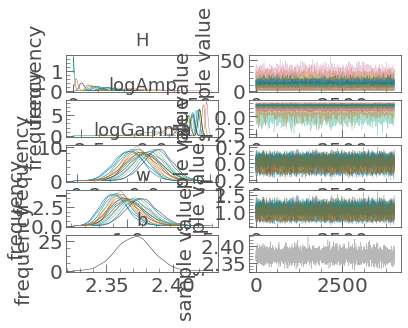

In [10]:
fit.plot(pars=['H','logAmp','logGamma','w','b'])
plt.show()

l = 0


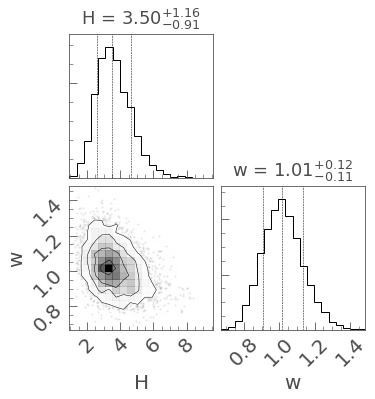

l = 0


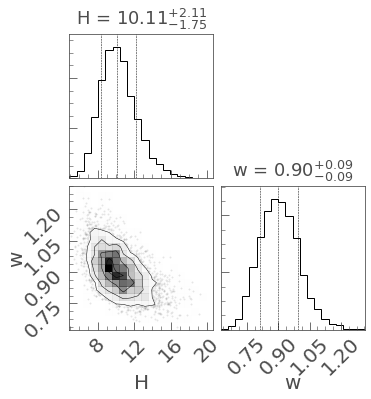

l = 0


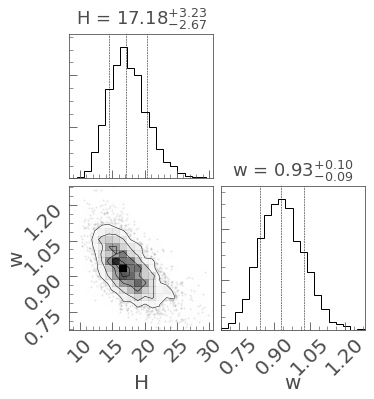

l = 0


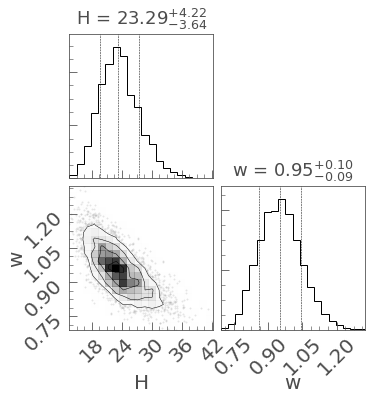

l = 0


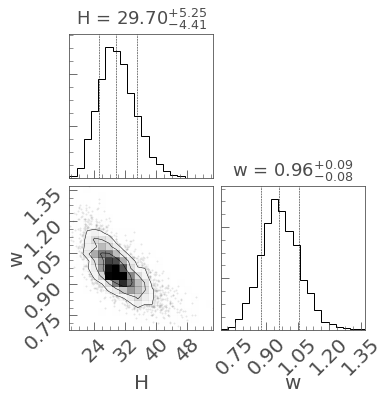

l = 0


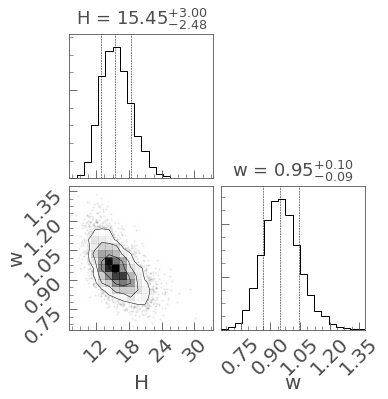

l = 0


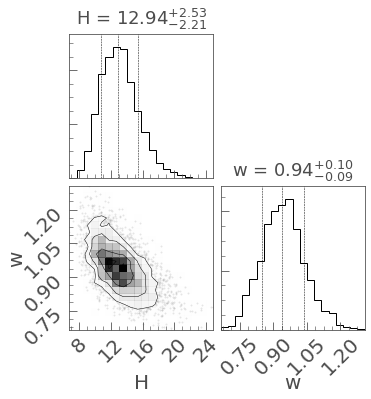

l = 0


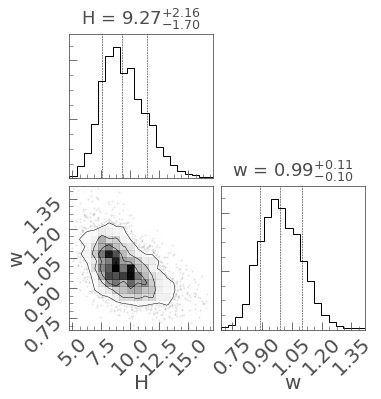

l = 0


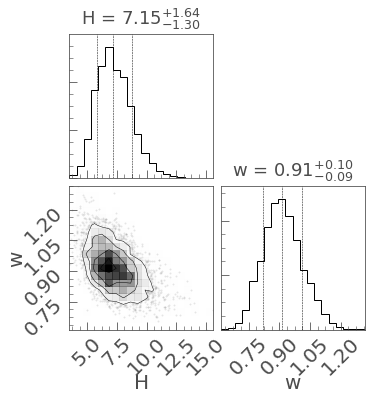

l = 2


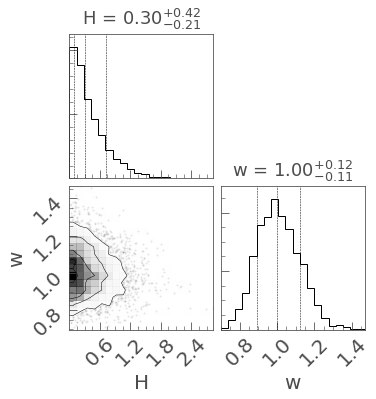

l = 2


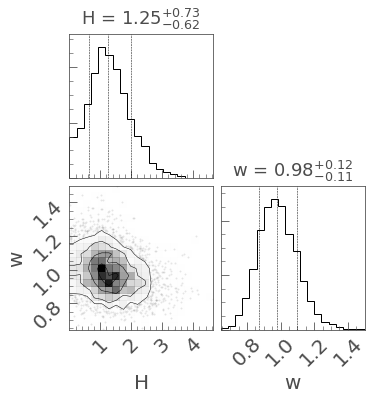

l = 2


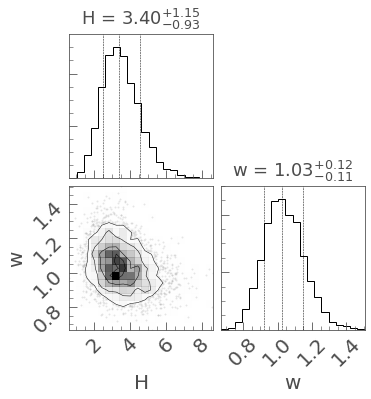

l = 2


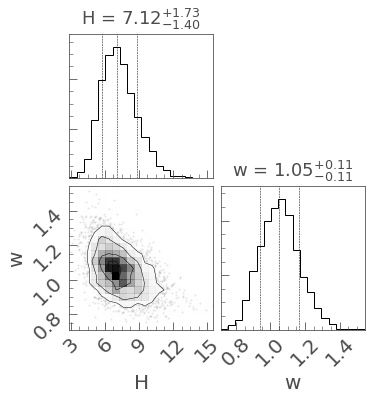

l = 2


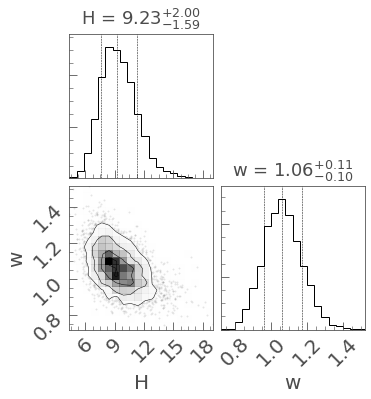

l = 2


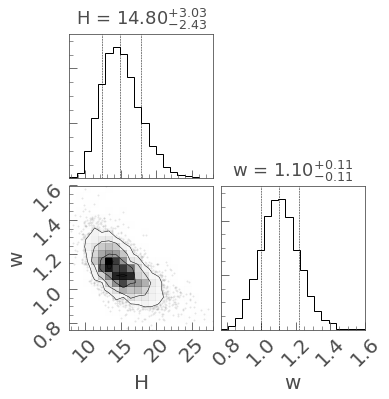

l = 2


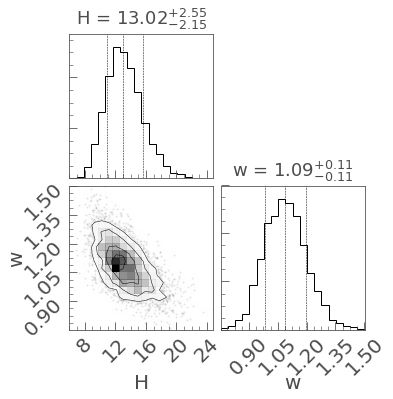

l = 2


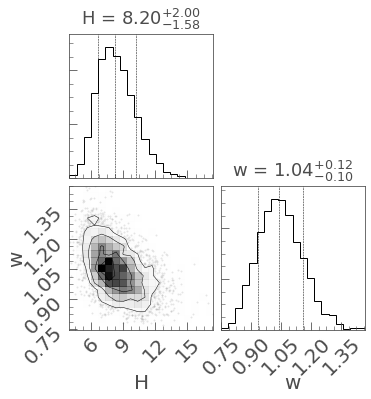

l = 2


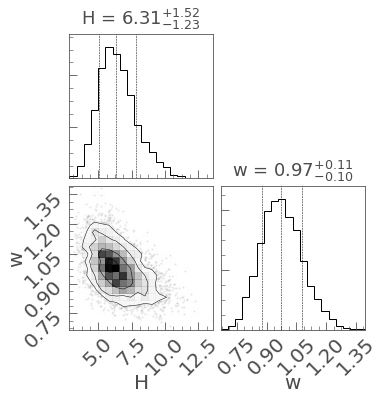

In [11]:
for idx in range(len(fit['H'].T)):
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx]])
    corner.corner(chain.T, labels=['H','w'], quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [12]:
  
def lorentzian(f, l, loc, H, w):
    model = H / (1 + (4/w**2)*(f - loc)**2)
    return model

model = np.ones(len(f))
for mode in range(len(modeids)):
    l = modeids[mode]
    loc = np.median(fit['locs'].T[mode])
    H = np.median(fit['H'].T[mode])
    w = np.median(fit['w'].T[mode])
    model += lorentzian(f, l, modelocs[mode], H, w)
fitlocs = np.median(fit['locs'],axis=0)

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


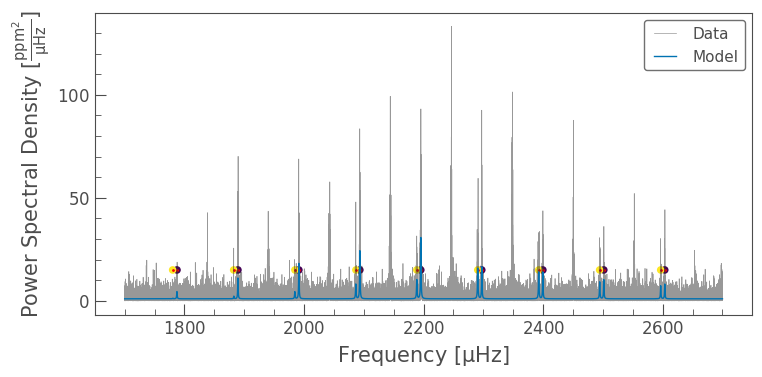

In [13]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5, label='Data')
plt.scatter(fitlocs, [15]*len(fitlocs),c=modeids,s=20)
plt.scatter(modelocs, [15]*len(modelocs),c='r')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()

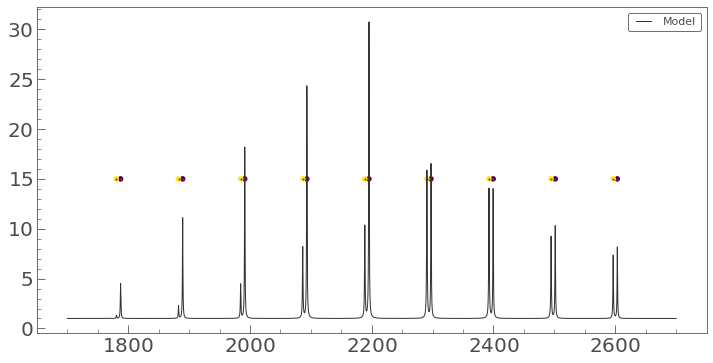

In [15]:
# pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
# ax = pg.plot(alpha=.5, label='Data')
fig = plt.figure(figsize=(12,6))
plt.scatter(fitlocs, [15]*len(fitlocs),c=modeids,s=20)
plt.scatter(modelocs, [15]*len(modelocs),c='r')
plt.plot(f, model, linewidth=1, label='Model')
plt.legend()